Introduction
--------------

The Fourier Transform is one of the most powerful and well known tools to analyse frequency behaviour. As such, it allows performing many operations in signal and imaging processing such as filtering, signal evaluation, signal characterization, etc.

In particular for medical applications some of the most widespread applications of Fourier Transform in signal processing are:
1. Filtering the signal to extract the information from the noise (i.e. the respiration rate will add important noise to an ECG signal but its frequency is much lower and can then be subtracted)
2. Evaluating the magnitude at specific frequencies of the signal to evaluate thresholds in an acquired signal (i.e. the detection of a seizure onset in EEG is characterized for large broadband signals)
3. The appearance of harmonics within a signal which may indicate there is an abnormality (i.e. the detection of harmonics in an ECG may indicate an arhytmia)

Fourier transforms present important properties that allow to combine analysis in frequency with simplicity:
1. Linearity: the transform of a sum is the sum of the transforms
2. Symmetry: the transform of the negative frequency is the conjugate of the transform
3. Convolution: the transform of a convolution is the product of each transform

In addition, filter design using frequency response is an important feature, and analysis of the response of a digital filter is usually done as a function of frequency:
1. It is often necessary to understand the behaviour of your signal before proposing the design of a filter
2. Once a filter is chosen, the impact of the order on the frequency behaviour of the filter and how that may affect the signal is important

The Discrete Fourier Transform (DFT) is the primary analysis tool for Fourier Transform nowadays since much of the processing is performed on digitized signals.

Using the DFT is equivalent to obtain a periodic signal out of a sequence (samples) of values.

This notebook will show how the DFT is implemented on a signal and how we can detect the presence and main frequency components of noise within the signal as well as the main frequency of the signal of interest.

We will work on an ultrasound signal that was acquired over time where some noise appears at some time point (we will determine when) and we will analyse the frequency component of the noise and the signal.

Some specifics about this acquired file: we obtained 15000 samples with a frequency of sampling of 125MHz, then waited another trigger and repeated for a total of 462 times.

We will also use this as an example on Python and simple signal analysis using Python.

We will start by opening the binary file where the signal was stored in unsigned integer (16 bits) and reading all the data into an array:



 The length of the file is: 6930000 as expected from 15000 samples x 462 lines

 The length of the time array is: 15000


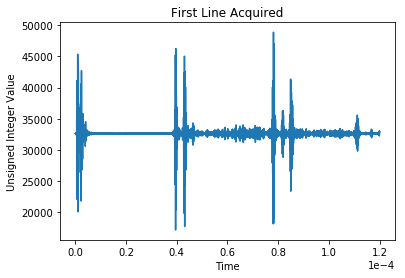

In [1]:
#we have first this command that initializes matplotlib (library) for plotting and we specify that we want those plots inline in 
# this notebook
%matplotlib inline





#Matplotlib sets up the matplotlib library for plotty
#now we import different packages that will allow to do math, lineal algebra, numerical operations, array operations and plotting
import scipy as Sci
import scipy.linalg
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

#we use a simple open command for the file (basic Python)
#rb means to read the binary file

f = open('UltrasoundSampleSignal.dat','rb')


#we read it using a numpy (therefore the np.) command that allows direct reading from file into an array
#count -1 means to read all the items from the file

AllSignal = np.fromfile(f,count=-1,dtype=np.uint16)



#to verify the size of the file I am printing here the lenght of that array
#str converts int to a string
print('\n The length of the file is: ' + str(len(AllSignal)) + ' as expected from 15000 samples x 462 lines')





#we will now populate an array for the time which we now is 1/125MHz step for a total of 15000
#start from x = 0, to x = 15000*Ts, steps of sample period
x=np.arange(0,15000/125e6,1/125e6)  #start,stop,step


print('\n The length of the time array is: ' + str(len(x)) )






#now we plot only the first line acquired (15000 samples)
#plot 0 - 15000 (line1)
plt.plot(x,AllSignal[:15000])
plt.title('First Line Acquired')
plt.xlabel('Time')
plt.ylabel('Unsigned Integer Value')

#scientfic notation for x axis. scilimits includes all numbers to be expressed in sci notation
plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
f.close() #close the file


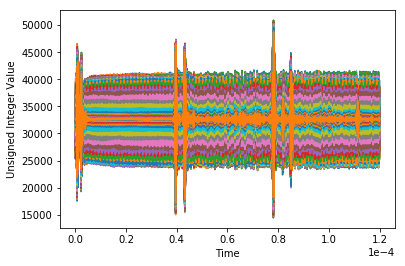

In [2]:
#We continue plotting other lines (we will plot every line and there are 462) 
totlines=np.arange(462)
for index in totlines:
    Signal=AllSignal[index*15000:(index+1)*15000]
    plt.plot(x,Signal)
    plt.xlabel('Time')
    plt.ylabel('Unsigned Integer Value')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

We can see from above that there are some lines that have noise.

We will first analyse the frequency component of a clean and a noisy line.

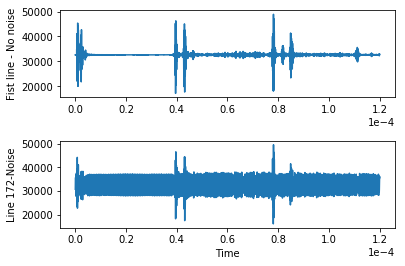

In [4]:
#The first line is clear
FirstLine=AllSignal[:15000]

#But some lines are very noisy, for instance line 172
NoisyLine=AllSignal[172*15000:(172+1)*15000]

#adjusts the (white) spacing between the two subplots
plt.subplots_adjust( hspace = 0.5 )

#2 rows 1 column grid, the last 1 is the plot located in the first row and first column
plt.subplot(211)
plt.plot(x,FirstLine)
plt.ylabel('Fist line - No noise')
# x axis in scientific notations.
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


#this plot will be located in the second row first column
plt.subplot(212)
plt.plot(x,NoisyLine)
plt.xlabel('Time')
plt.ylabel('Line 172-Noise')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

Now that we have a noisy and a clean line we will obtain the frequency component of those signals using DFT.

First lets define the DFT:

$$ A_k=\sum_{m=0}^{n-1}a_m \exp \left(-2\pi i \frac{mk}{n} \right ) [k=0,...,n-1] $$

If we notice the signal has a dc component (not centered in zero) so unless we want to have a spectrum with a large value of dc or zero frequency we will first remove the dc component (by substracting the mean of the data).

We will then obtain the DFT.

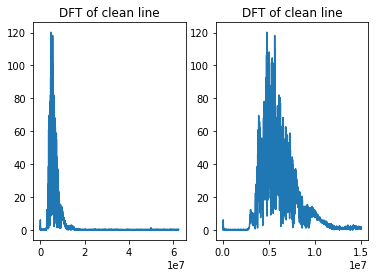

In [5]:
#we first eliminate dc
dataF=FirstLine-np.mean(FirstLine)

#the frequencies after fft will be between 0 and 1/2 of the sampling frequency
#Start at 0Hz, stop at 62.5MHz because it is the maximum frequency from the sampled signal. It doesn't contain frequency components
#past 62.5MHz since the sampling was done following nyquist critiera
#steps of 8333.Hz
f=np.arange(0,125e6/2,125e6/15000)
Y=np.fft.fft(dataF)

#l which is 15000, is used to normalize all the data so it doesn't contain massive amplitudes
L=len(dataF)

#contatins complex values, therefore the values are taken as the absolute. L is for normalizing 
PyyClean=abs(Y)/L








#note: we are showing just L/2 elements which are the positive frequencies and we are normalizing
# 1 row, 2 columns
plt.subplot(121)
plt.plot(f, PyyClean[0:7500])
plt.title('DFT of clean line')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#Zooming into just less than 15MHz
#gets location of the f array where 15MHz is located. Then uses this position as the end of plot on the x axis
inx=np.where(f>15e6)
inx=inx[0]

#what would be the length of inx? (62.5MHz - 15.0MHz)/8333.3Hz = 5700


plt.subplot(122)

#plots from 0 to the first array position of index which is the x location of 15MHz. Then plots the amplitudes
#from that range 
plt.plot(f[0:inx[0]], PyyClean[0:inx[0]])
plt.title('DFT of clean line')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

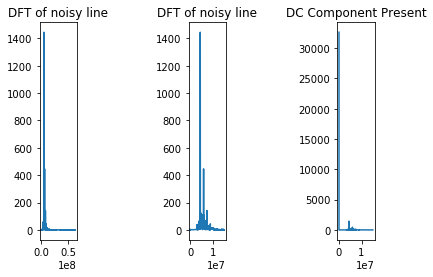

In [17]:
#now we repeat for the noisy line
#we first eliminate dc
# if you do not remove the dc component you will have a massive peak at 0Hz. 
# Example below

plt.subplots_adjust( wspace = 3 )
dataX=NoisyLine
dataN=NoisyLine-np.mean(NoisyLine)
L=len(dataN)
L=len(dataX)


#the frequencies after fft will be between 0 and 1/2 of the sampling frequency
f=np.arange(0,125e6/2,125e6/15000)

# DFT OF NOISY LINE
Y=np.fft.fft(dataN)

# DFT OF NOISY LINE WITH DC COMPONENT
Z=np.fft.fft(dataX)


PyyNoisy=abs(Y)/L
PyyNoisy_X=abs(Z)/L




#note: we are showing just L/2 elements which are the positive frequencies and we are normalizing
plt.subplot(131)
plt.plot(f, PyyNoisy[:7500])
plt.title('DFT of noisy line')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


#Zooming into just less than 15MHz
inx=np.where(f>15e6)
inx=inx[0]
plt.subplot(132)
plt.plot(f[:inx[0]], PyyNoisy[:inx[0]])
plt.title('DFT of noisy line')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))




#DC COMPONENT PRESENT
plt.subplot(133)
plt.plot(f[:inx[0]], PyyNoisy_X[:inx[0]])
plt.title('DC Component Present')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

We can clearly see there are large noise peaks at various frequencies. These are actually harmonics of 1.5MHz and it is strong at 4.5MHz.

We will use this here to determine a criteria for noise and later on to filter this signal.

A nice tool: let's use interactive graph to "see" where those peaks are. For this, the backend for matplotlib to use is called nbagg so we will change the inline magic for nbagg.


<IPython.core.display.Javascript object>


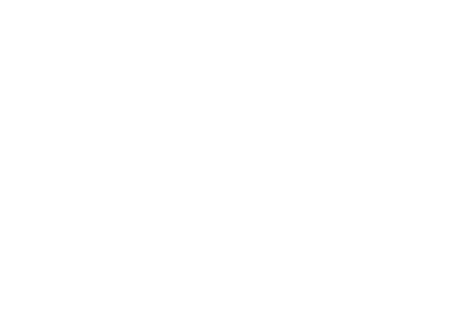

<IPython.core.display.Javascript object>


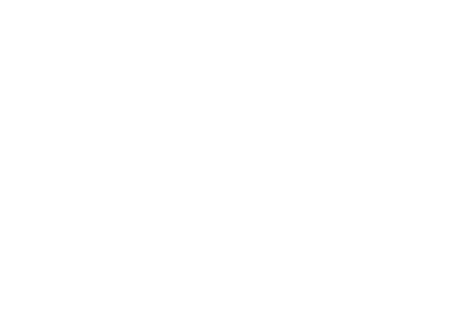

In [18]:

#interactive plotting tool
%matplotlib nbagg

##AND WE REPEAT THE CODE

#now we repeat for the noisy line
#we first eliminate dc
dataN=NoisyLine-np.mean(NoisyLine)
L=len(dataN)
#the frequencies after fft will be between 0 and 1/2 of the sampling frequency
f=np.arange(0,125e6/2,125e6/15000)
Y=np.fft.fft(dataN)
PyyNoisy=abs(Y)/L
#note: we are showing just L/2 elements which are the positive frequencies and we are normalizing
plt.subplot(121)
plt.plot(f, PyyNoisy[:7500])
plt.title('DFT of noisy line')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#Zooming into just less than 15MHz
inx=np.where(f>15e6)
inx=inx[0]
plt.subplot(122)
plt.plot(f[:inx[0]], PyyNoisy[:inx[0]])
plt.title('DFT of noisy line')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

## Summary

In this example, we executed the Discrete Fourier Transform (DFT) on a clear and noisy signal.

Test your knowdelge:

Find which line(s) in the acquisition have a noticeable noise (we will define this point as when the noise peak at 4.5MHz reaches an amplitude in the FFT as high as the maximum in the clear line)
    1. Use a loop in the code
    2. Display all the line numbers that fall under this criteria
    3. Display the amplitude of the peak at 4.5MHz for each noisy line

Comments and corrections welcome!

References
---------------

* Oppenheim, A. V., and A. S. Willsky. "Signals and Systems." Prentice-Hall, (1997).

Use a loop in the code

Display all the line numbers that fall under this crti